In [1]:
%matplotlib inline

from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert

from skimage.morphology import medial_axis

import cv2 as cv

from skimage.morphology import thin


(403, 341)


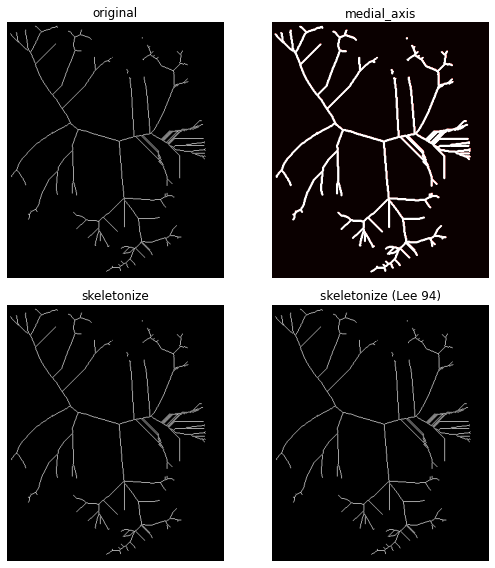

In [3]:
# Generate the data
#blobs = data.binary_blobs(200, blob_size_fraction=.2, volume_fraction=.35, seed=1)

#read 3D rbg image as 2D greyscale nparray
blobs = cv.imread(cv.samples.findFile("../Lake_Murray_Map_Skeletons/SE_corner_medial_axis.png"),0) 
# last parameter 0 = greyscale 1 = color -1 = unchanged 

#convert data from int to np bool 
blobs = blobs > 127

print(blobs.shape)

# Compute the medial axis (skeleton) and the distance transform
skel, distance = medial_axis(blobs, return_distance=True)

# Compare with other skeletonization algorithms
skeleton = skeletonize(blobs)
skeleton_lee = skeletonize(blobs, method='lee')

# Distance to the background for pixels of the skeleton
dist_on_skel = distance * skel

fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(blobs, cmap=plt.cm.gray)
ax[0].set_title('original')
ax[0].axis('off')

ax[1].imshow(dist_on_skel, cmap='hot')
ax[1].contour(blobs, [0.5], colors='w')
ax[1].set_title('medial_axis')
ax[1].axis('off')

ax[2].imshow(skeleton, cmap=plt.cm.gray)
ax[2].set_title('skeletonize')
ax[2].axis('off')

ax[3].imshow(skeleton_lee, cmap=plt.cm.gray)
ax[3].set_title("skeletonize (Lee 94)")
ax[3].axis('off')

fig.tight_layout()
plt.show()

#cv.imwrite('lake_medial_axis.png', dist_on_skel * 255)
#cv.imwrite('lake_skeleton.png', skeleton * 255)
#cv.imwrite('lake_skeleton_lee94.png', skeleton_lee )


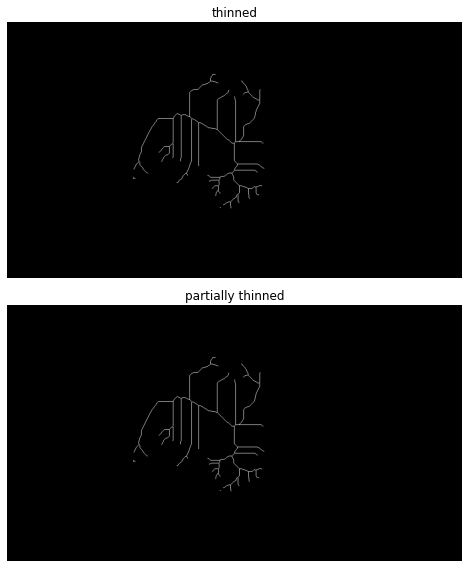

True

In [13]:
thinned = thin(blobs)
thinned_partial = thin(blobs, max_iter=10)

fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True, sharey=True)
#fig, axes = plt.subplots(1, 2)
ax = axes.ravel()


ax[0].imshow(thinned, cmap=plt.cm.gray)
ax[0].set_title('thinned')
ax[0].axis('off')

ax[1].imshow(thinned_partial, cmap=plt.cm.gray)
ax[1].set_title('partially thinned')
ax[1].axis('off')

fig.tight_layout()
plt.show()

cv.imwrite('lake_thinned.png', thinned * 255)
cv.imwrite('lake_thinned_partial.png', thinned_partial * 255)






In [9]:

import cv2 as cv

#use thinned graph of corner
#iterate over each pixel
    #check neighboring pixels and count how many are "marked"
        #if num neighbors > 2 or num neighbors < 2
            #pixel = node
        #else
            #pixel = edge
#read 3D rbg image as 2D greyscale nparray
blobs = cv.imread(cv.samples.findFile("../Lake_Murray_Map_Skeletons/SE_corner_thinned.png"),0) 
# last parameter 0 = greyscale 1 = color -1 = unchanged 

#convert data from int to np bool 
blobs = blobs > 127 
#blobs is now a (540,960) 2 D array

print(blobs.shape)

ydim = blobs.shape[0] #num rows 540
xdim = blobs.shape[1] #num columns 960


# measure some skeleton metrics down here 
sum_local_neighbors = 0 #number of adjacent skeleton pixels 
sum_num_nodes = 0 #total number pixels that are of nodes of the skeleton
sum_num_edges = 0 #total number pixels that are of edges ots 
sum_num_endpoints = 0 #total number of pixels that are end points of the skeleton
sum_num_islands = 0 #total number of pixels that are isolated
sum_points_length = 0 #total number of skeleton pixels aka length of skeleton

total_num_edgelines = 0 #how many actual edges are there in the network

#lets make a bunch of arrays storing : node locations, endpoint locations, edge locations,island locations  
node_locations = []
edge_locations = []
island_locations = []

#here we are going to find the nodes and edges and endpoints

for row in range(0,ydim): #iterate through rows 
    for col in range(0,xdim): #iterate through columns
        
        if blobs[row][col] == True: #if pixel is skeleton add 1 to length of skeleton
            sum_points_length +=1
            
            #find the sum of the local neighbors included in the skeleton (including self): 1 = solo ,2= endpoint, 3 = edge , 4+ = node 
            for i in range(-1,2):
                for j in range(-1,2):
                    try: #this because there may be points on the edge of the picture
                        sum_local_neighbors += int(blobs[row +i][col +j])
                    except:
                        pass
            
            #figure out num nodes endpoints and edges
            if sum_local_neighbors >= 4:
                sum_num_nodes += 1
                total_num_edgelines += sum_local_neighbors -1 #count connection points (-1 to remove self counting)
            elif sum_local_neighbors == 3:
                sum_num_edges += 1
            elif sum_local_neighbors == 2:
                sum_num_endpoints += 1
                total_num_edgelines += sum_local_neighbors -1 #count connection points (-1 to remove self counting)
            else: 
                print("isolated point at ", blobs[row][col])
                sum_num_islands +=1

            #reset counter     
            sum_local_neighbors = 0

#error check
if sum_num_nodes + sum_num_edges + sum_num_endpoints + sum_num_islands == sum_points_length:
    print("all good")
else:
    print("f*&!")

total_num_edgelines = total_num_edgelines / 2 #because each edge has two endpoints 
print("this skeleton has {0} edge lines, {1} nodes, {2} endpoints, and {3} islands. \nthe skeleton is of length {4} pixels.".format(total_num_edgelines , sum_num_nodes, sum_num_endpoints, sum_num_islands, sum_points_length))

print("the edgelines are of average length {0}, .".format( sum_num_edges / total_num_edgelines))


(403, 341)
all good
this skeleton has 315.0 edge lines, 183 nodes, 60 endpoints, and 0 islands. 
the skeleton is of length 3177 pixels.
the edgelines are of average length 9.314285714285715, .
